In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['AMD','EPAM','APPS','ASML','AUDC','DSGX','TTD','IDXX','BDSI','CDMO','ICLR','MEDP','OPCH','OPRX','RGEN',
          'TNDM','XOMA','CBRE','SBAC','ODFL','GLDD','HSON', 'KRNT','RCII','SAIA','SBLK','TRNS','HLT','TSLA',
          'CHDN','CLAR','FIVE','FOXF','LULU','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     1259 non-null   float64
 1   EPAM    1259 non-null   float64
 2   APPS    1259 non-null   float64
 3   ASML    1259 non-null   float64
 4   AUDC    1259 non-null   float64
 5   DSGX    1259 non-null   float64
 6   TTD     1259 non-null   float64
 7   IDXX    1259 non-null   float64
 8   BDSI    1259 non-null   float64
 9   CDMO    1259 non-null   float64
 10  ICLR    1259 non-null   float64
 11  MEDP    1259 non-null   float64
 12  OPCH    1259 non-null   float64
 13  OPRX    1259 non-null   float64
 14  RGEN    1259 non-null   float64
 15  TNDM    1259 non-null   float64
 16  XOMA    1259 non-null   float64
 17  CBRE    1259 non-null   float64
 18  SBAC    1259 non-null   float64
 19  ODFL    1259 non-null   float64
 20  GLDD    1259 non-null   float64
 21  HSON    1259 non-nu

## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Close']
    save_dataframe_to_csv('close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('close', ticker)
    add_daily_return_to_df('close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('close', x)
    
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ['AMD','EPAM','APPS','ASML','AUDC','DSGX','TTD','IDXX','BDSI','CDMO','ICLR','MEDP','OPCH','OPRX','RGEN',
          'TNDM','XOMA','CBRE','SBAC','ODFL','GLDD','HSON', 'KRNT','RCII','SAIA','SBLK','TRNS','HLT','TSLA',
          'CHDN','CLAR','FIVE','FOXF','LULU','^FVX']

#add in the weightage of stocks
port_shares = [0.026583,0.034851,0.096294,0.048018,0.041109,0.006993,0.046149,0.048508,0.008168,0.018970,0.017408,
              0.006022,0.000022,0.043910,0.047034,0.000492,0.009466,0.064368,0.135632,0.079597,0.001491,0.009026,
              0.008944,0.003649,0.000157,0.004097,0.043038,0.002017,0.046972,0.011787,0.031827,0.006205,0.012434,
              0.038754,0.000000]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,AMD,EPAM,APPS,ASML,AUDC,DSGX,TTD,IDXX,BDSI,CDMO,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.303844,2.218615,0.067406,5.303588,0.270908,0.148601,0.124279,5.704541,0.014294,0.039837,...,0.113364,2.038491,0.584242,0.179464,0.251178,0.333853,2.590705,0.0,45.166000,NaN
2017-01-04,0.303844,2.243010,0.067406,5.278138,0.267620,0.150000,0.125064,5.624502,0.014294,0.041165,...,0.116986,2.132435,0.585225,0.184228,0.252481,0.346909,2.689915,0.0,45.479736,0.006946
2017-01-05,0.298793,2.256602,0.067406,5.341522,0.258576,0.147902,0.126679,5.624988,0.015111,0.039837,...,0.115614,2.130180,0.584832,0.182640,0.254095,0.347530,2.663563,0.0,45.264323,-0.004736
2017-01-06,0.300920,2.330486,0.065480,5.335760,0.263509,0.148601,0.127833,5.741407,0.015519,0.039837,...,0.115917,2.151411,0.576581,0.188993,0.246463,0.343800,2.645735,0.0,45.345928,0.001803
2017-01-09,0.305439,2.329441,0.069332,5.401545,0.259398,0.148252,0.131248,5.773422,0.015111,0.039837,...,0.114888,2.172737,0.568526,0.190581,0.240878,0.341935,2.642635,0.0,45.349443,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4.103352,24.291147,6.108891,38.963245,1.432649,0.572167,4.507834,31.764980,0.025729,0.574222,...,0.313220,51.384547,2.795759,0.864421,1.222137,2.057703,15.530665,0.0,302.240410,0.022838
2021-12-28,4.071186,23.775353,6.002968,38.643447,1.422783,0.573426,4.374464,31.592292,0.025402,0.555442,...,0.312675,51.127611,2.814971,0.866013,1.219096,2.043528,15.504313,0.0,299.916958,-0.007687
2021-12-29,3.941195,23.623403,5.894156,38.509475,1.431004,0.576503,4.272013,31.806211,0.025321,0.574981,...,0.313381,51.020514,2.823458,0.864740,1.279347,2.053599,15.540354,0.0,300.179255,0.000875


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,AMD,EPAM,APPS,ASML,AUDC,DSGX,TTD,IDXX,BDSI,CDMO,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.303844,2.218615,0.067406,5.303588,0.270908,0.148601,0.124279,5.704541,0.014294,0.039837,...,0.113364,2.038491,0.584242,0.179464,0.251178,0.333853,2.590705,0.0,45.166000,NaN
2017-01-04,0.303844,2.243010,0.067406,5.278138,0.267620,0.150000,0.125064,5.624502,0.014294,0.041165,...,0.116986,2.132435,0.585225,0.184228,0.252481,0.346909,2.689915,0.0,45.479736,0.006946
2017-01-05,0.298793,2.256602,0.067406,5.341522,0.258576,0.147902,0.126679,5.624988,0.015111,0.039837,...,0.115614,2.130180,0.584832,0.182640,0.254095,0.347530,2.663563,0.0,45.264323,-0.004736
2017-01-06,0.300920,2.330486,0.065480,5.335760,0.263509,0.148601,0.127833,5.741407,0.015519,0.039837,...,0.115917,2.151411,0.576581,0.188993,0.246463,0.343800,2.645735,0.0,45.345928,0.001803
2017-01-09,0.305439,2.329441,0.069332,5.401545,0.259398,0.148252,0.131248,5.773422,0.015111,0.039837,...,0.114888,2.172737,0.568526,0.190581,0.240878,0.341935,2.642635,0.0,45.349443,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4.103352,24.291147,6.108891,38.963245,1.432649,0.572167,4.507834,31.764980,0.025729,0.574222,...,0.313220,51.384547,2.795759,0.864421,1.222137,2.057703,15.530665,0.0,302.240410,0.022838
2021-12-28,4.071186,23.775353,6.002968,38.643447,1.422783,0.573426,4.374464,31.592292,0.025402,0.555442,...,0.312675,51.127611,2.814971,0.866013,1.219096,2.043528,15.504313,0.0,299.916958,-0.007687
2021-12-29,3.941195,23.623403,5.894156,38.509475,1.431004,0.576503,4.272013,31.806211,0.025321,0.574981,...,0.313381,51.020514,2.823458,0.864740,1.279347,2.053599,15.540354,0.0,300.179255,0.000875


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,AMD,EPAM,APPS,ASML,AUDC,DSGX,TTD,IDXX,BDSI,CDMO,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.303844,2.218615,0.067406,5.303588,0.270908,0.148601,0.124279,5.704541,0.014294,0.039837,...,0.113364,2.038491,0.584242,0.179464,0.251178,0.333853,2.590705,0.0,45.166000,NaN
2017-01-04,0.303844,2.243010,0.067406,5.278138,0.267620,0.150000,0.125064,5.624502,0.014294,0.041165,...,0.116986,2.132435,0.585225,0.184228,0.252481,0.346909,2.689915,0.0,45.479736,0.006946
2017-01-05,0.298793,2.256602,0.067406,5.341522,0.258576,0.147902,0.126679,5.624988,0.015111,0.039837,...,0.115614,2.130180,0.584832,0.182640,0.254095,0.347530,2.663563,0.0,45.264323,-0.004736
2017-01-06,0.300920,2.330486,0.065480,5.335760,0.263509,0.148601,0.127833,5.741407,0.015519,0.039837,...,0.115917,2.151411,0.576581,0.188993,0.246463,0.343800,2.645735,0.0,45.345928,0.001803
2017-01-07,0.300920,2.330486,0.065480,5.335760,0.263509,0.148601,0.127833,5.741407,0.015519,0.039837,...,0.115917,2.151411,0.576581,0.188993,0.246463,0.343800,2.645735,0.0,45.345928,0.001803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,4.103352,24.291147,6.108891,38.963245,1.432649,0.572167,4.507834,31.764980,0.025729,0.574222,...,0.313220,51.384547,2.795759,0.864421,1.222137,2.057703,15.530665,0.0,302.240410,0.022838
2021-12-28,4.071186,23.775353,6.002968,38.643447,1.422783,0.573426,4.374464,31.592292,0.025402,0.555442,...,0.312675,51.127611,2.814971,0.866013,1.219096,2.043528,15.504313,0.0,299.916958,-0.007687
2021-12-29,3.941195,23.623403,5.894156,38.509475,1.431004,0.576503,4.272013,31.806211,0.025321,0.574981,...,0.313381,51.020514,2.823458,0.864740,1.279347,2.053599,15.540354,0.0,300.179255,0.000875


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['AMD','EPAM','APPS','ASML','AUDC','DSGX','TTD','IDXX','BDSI','CDMO','ICLR','MEDP','OPCH','OPRX','RGEN',
          'TNDM','XOMA','CBRE','SBAC','ODFL','GLDD','HSON', 'KRNT','RCII','SAIA','SBLK','TRNS','HLT','TSLA',
          'CHDN','CLAR','FIVE','FOXF','LULU','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2017-01-03,45.166000
2017-01-04,45.479736
2017-01-05,45.264323
2017-01-06,45.345928
2017-01-07,45.345928
...,...
2021-12-27,302.240410
2021-12-28,299.916958
2021-12-29,300.179255


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


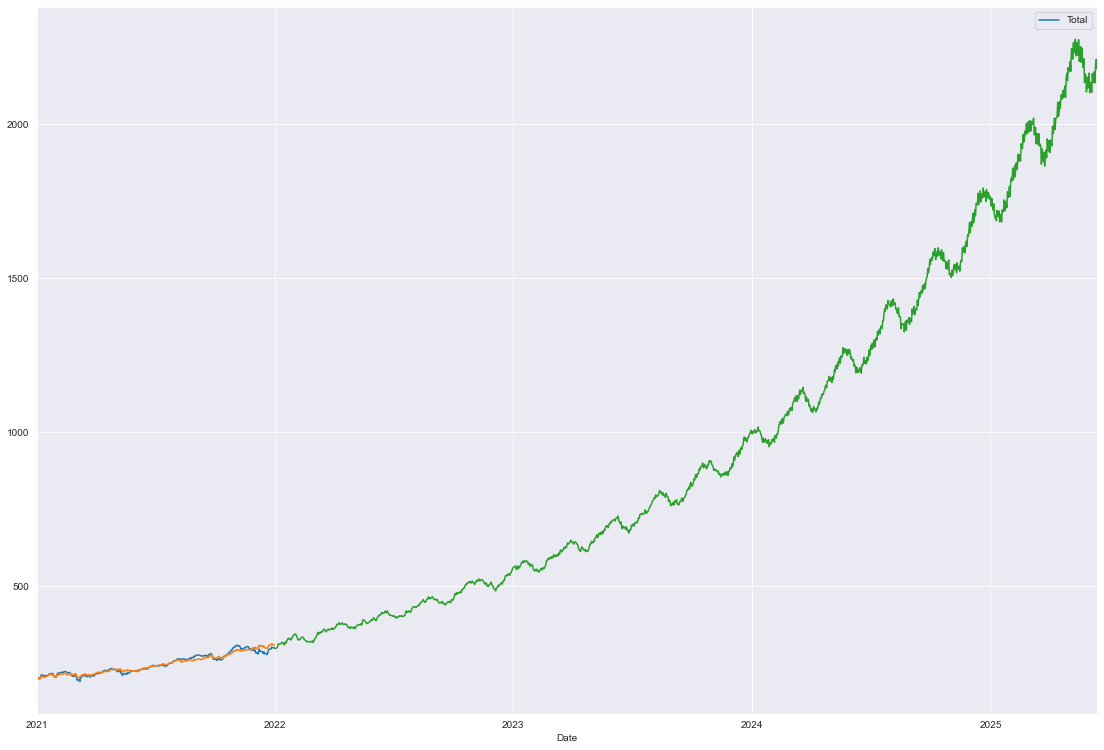

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2021-12-31     298.900452
2022-01-01     298.233393
2022-01-02     297.189574
2022-01-03     297.809842
2022-01-04     300.012982
                 ...     
2025-06-09    2169.782492
2025-06-10    2133.864007
2025-06-11    2193.677355
2025-06-12    2209.673503
2025-06-13    2178.352641
Freq: D, Length: 1261, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2021-12-31,298.900452
2022-01-01,298.233393
2022-01-02,297.189574
2022-01-03,297.809842
2022-01-04,300.012982
...,...
2025-06-09,2169.782492
2025-06-10,2133.864007
2025-06-11,2193.677355
2025-06-12,2209.673503


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.002232
2022-01-02,-0.005724
2022-01-03,-0.003649
2022-01-04,0.003722
...,...
2025-06-09,6.259214
2025-06-10,6.139046
2025-06-11,6.339157
2025-06-12,6.392674


In [26]:
#calculate annualized volatility
annualized_vol = np.sqrt(np.log(forecast / forecast.shift(1)).var()) * np.sqrt(252)
annualized_vol*100

17.309209442882135